# Set Up

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)

In [5]:
#set paths
current_directory = os.getcwd()
base_dir = f'{os.path.dirname(current_directory)}/'
data_dir = f'{base_dir}Source_Data/'
fig_dir = f'{base_dir}/figures/'


In [6]:
# Color palette for timepoints
ses_palette = {
    'ses-1': '#440154',
    'ses-2': '#414487', 
    'ses-3': '#2a788e',
    'ses-4': '#22a884',
    'ses-5': '#7ad151',
}

ses2color = '#4a4c7f'
ses3color = '#377182'
ses5color = '#80c161'

#load data
all_data = pd.read_csv(f'{data_dir}fig_6.csv')

# Convert 'ses' to an ordered categorical type
all_data['ses'] = pd.Categorical(
    all_data['ses'], 
    categories=['ses-1', 'ses-2', 'ses-3', 'ses-4', 'ses-5'], 
    ordered=True
)

# Convert 'subgroup' to a categorical type with specified order
all_data['study_group'] = pd.Categorical(
    all_data['study_group'], 
    categories=['intervention', 'dys_control', 'typ_control'], 
    ordered=True
)

# ses-2 to ses-3 change

In [13]:
# Define the ROI and filter the dataset
ROI = 'VWFA2'
size = all_data[
    (all_data['ses'] != 'ses-1') &
    (all_data['ses'] != 'ses-4') &
    (all_data['ses'] != 'ses-5') &
    (all_data['roi'] == ROI)]

# Filter control data
control_data = size.query('ses=="ses-2" & study_group=="typ_control"')

# Calculate average log_size (& quartiles) and wj_brs for the control group
avg_log_size_control = np.nanmean(control_data['log_size'])
q25_log_size_control = np.nanquantile(control_data['log_size'],[.25])
q75_log_size_control = np.nanquantile(control_data['log_size'],[.75])
avg_brs_control = np.nanmean(control_data['wj_brs'])

# Filter intervention data
intervention_data = size.query('study_group=="intervention"').dropna(subset=['MRI_days_ses2'])

# Calculate time needed for intervention group to reach BRS of 100
lme_wj_brs = smf.mixedlm("wj_brs ~ MRI_days_ses2", intervention_data, groups=intervention_data["sub"]).fit()
slope_wj_brs = lme_wj_brs.params["MRI_days_ses2"]
current_wj_brs = np.nanmean(intervention_data["wj_brs"])

time_needed = (avg_brs_control - current_wj_brs) / slope_wj_brs
x_max = time_needed * 1.1

# Fit a model to predict size as a function of time
lme_log_size = smf.mixedlm("log_size ~ MRI_days_ses2", intervention_data, groups=intervention_data["sub"]).fit()
intercept_log_size = lme_log_size.params["Intercept"]
slope_log_size = lme_log_size.params["MRI_days_ses2"]

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    "MRI_days_ses2": np.linspace(0, x_max, 100)
})
predictions_df["predicted_log_size"] = intercept_log_size + slope_log_size * predictions_df["MRI_days_ses2"]

# calculate predicted size of the VWFA for the intervention group
predicted_size_int = intercept_log_size + (slope_log_size * time_needed)


In [14]:
## for plotting purposes only - separate the data
intervention_data_ses2 = intervention_data.query('ses=="ses-2"')
intervention_data_ses2=intervention_data_ses2[['sub','ses','roi','hemi','log_size','MRI_days_ses2']]
intervention_data_ses3 = intervention_data.query('ses=="ses-3"')
intervention_data_ses3=intervention_data_ses3[['sub','ses','roi','hemi','log_size','MRI_days_ses2']]

## find average of ses3 days and replace for all subs for plotting only
avg_int_ses3_days = np.mean(intervention_data_ses3['MRI_days_ses2'])
intervention_data_ses3['MRI_days_ses2'] = avg_int_ses3_days

#combine data
plot_df = pd.concat([intervention_data_ses2,intervention_data_ses3],ignore_index=True)

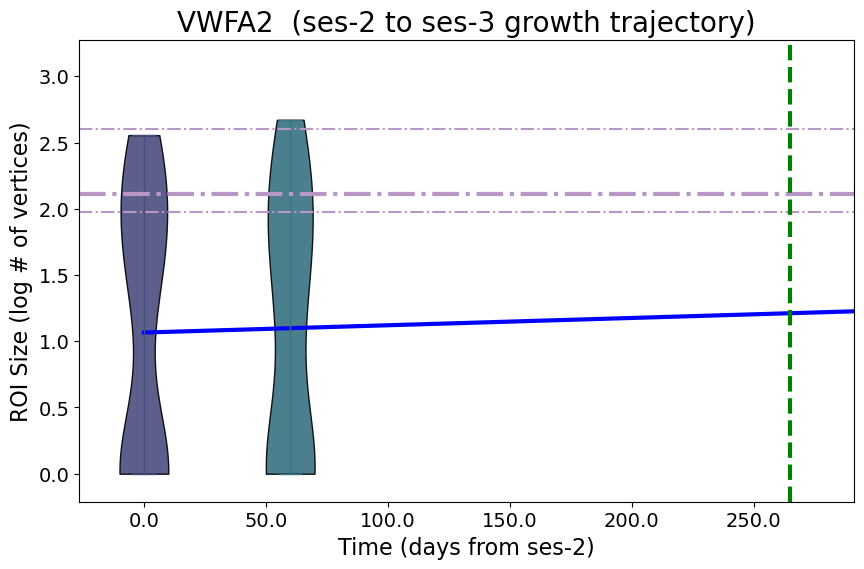

In [15]:
save_fig = False
fig, ax = plt.subplots(figsize=(10, 6))

# Overlay the model prediction line
plt.plot(
    predictions_df["MRI_days_ses2"],
    predictions_df["predicted_log_size"],
    color="blue",
    linewidth=3,
    label="Model Prediction"
)

violin_parts = plt.violinplot(dataset = intervention_data_ses2['log_size'],positions=[0],widths=[20])
for pc in violin_parts['bodies']:
    pc.set_facecolor(ses2color)
    pc.set_alpha(0.9)
    pc.set_edgecolor('black')

violin_parts2 = plt.violinplot(dataset = intervention_data_ses3['log_size'],positions=[avg_int_ses3_days],widths=[20])
for pc2 in violin_parts2['bodies']:
    pc2.set_facecolor(ses3color)
    pc2.set_alpha(0.9)
    pc2.set_edgecolor('black')

# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor(ses2color)
    vp.set_linewidth(1)
    vp2 = violin_parts2[partname]
    vp2.set_edgecolor(ses3color)
    vp2.set_linewidth(1)

# Add reference lines
plt.axhline(
    y=avg_log_size_control,
    # color="red",
    color='#b897c6',
    linestyle="dashdot",
    linewidth=3,
    label="Avg Log Size (Control)"
)
plt.axhline(
    y=q25_log_size_control,
    # color="red",
    color='#b897c6',
    linestyle="dashdot",
    linewidth=1.5,
    label="Avg Log Size (Control)"
)
plt.axhline(
    y=q75_log_size_control,
    # color="red",
    color='#b897c6',
    linestyle="dashdot",
    linewidth=1.5,
    label="Avg Log Size (Control)"
)
plt.axvline(
    x=time_needed,
    color="green",
    linestyle="dashed",
    linewidth=3,
    label="Time Needed"
)

# Set axis limits
plt.xlim(time_needed*-.1, time_needed*1.1)
plt.ylim(avg_log_size_control*-.1, avg_log_size_control*1.55)

# Define x-axis ticks and labels
plt.xticks(
    ticks=np.arange(0, time_needed, 50),  # Tick marks at 0, 50, 100, ..., 250
    labels=[f"{tick}" for tick in np.arange(0, time_needed, 50)],size=14
)
plt.yticks(size=14)

# Add title, labels, and legend
plt.title(f"{ROI}  (ses-2 to ses-3 growth trajectory)", size=20)
plt.xlabel("Time (days from ses-2)",size=16)
plt.ylabel("ROI Size (log # of vertices)",size=16)
# plt.legend()

if save_fig:
    plt.savefig(f'{fig_dir}fig_6_{ROI}_2-3.svg',bbox_inches="tight",transparent=True, dpi=400)
plt.show()


# ses-2 to ses-5 change

In [30]:
# Define the ROI and filter the dataset
ROI = 'VWFA2'
size = all_data[
    (all_data['ses'] != 'ses-1') &
    (all_data['ses'] != 'ses-3') &
    (all_data['ses'] != 'ses-4') &
    (all_data['roi'] == ROI)]

# Filter intervention data
intervention_data = size.query('study_group=="intervention"').dropna(subset=['MRI_days_ses2'])

# Fit a model to predict size as a function of time
lme_log_size = smf.mixedlm("log_size ~ MRI_days_ses2", intervention_data, groups=intervention_data["sub"]).fit()
intercept_log_size = lme_log_size.params["Intercept"]
slope_log_size = lme_log_size.params["MRI_days_ses2"]

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    "MRI_days_ses2": np.linspace(0, x_max, 100)
})
predictions_df["predicted_log_size"] = intercept_log_size + slope_log_size * predictions_df["MRI_days_ses2"]

# calculate predicted size of the VWFA for the intervention group
predicted_size_int = intercept_log_size + (slope_log_size * time_needed)

In [31]:
## for plotting purposes only - separate teh data
intervention_data_ses2 = intervention_data.query('ses=="ses-2"')
intervention_data_ses2=intervention_data_ses2[['sub','ses','roi','hemi','log_size','MRI_days_ses2']]
intervention_data_ses5 = intervention_data.query('ses=="ses-5"')
intervention_data_ses5=intervention_data_ses5[['sub','ses','roi','hemi','log_size','MRI_days_ses2']]

## find average of ses5 days and replace for all subs for plotting only
avg_int_ses5_days = np.mean(intervention_data_ses5['MRI_days_ses2'])
intervention_data_ses5['MRI_days_ses2'] = avg_int_ses5_days

#combine data
plot_df = pd.concat([intervention_data_ses2,intervention_data_ses5],ignore_index=True)

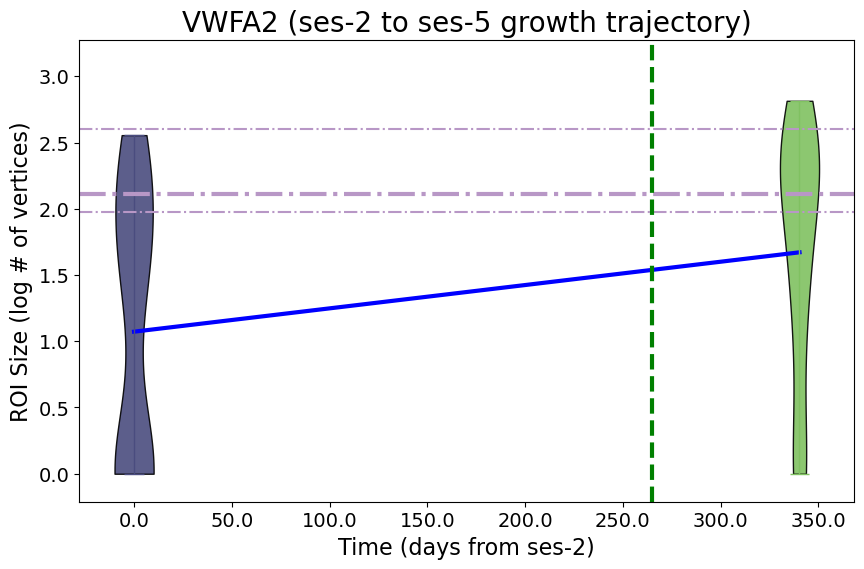

In [32]:
save_fig = False
fig, ax = plt.subplots(figsize=(10, 6))

from scipy.interpolate import interp1d

# Create an interpolation function based on the predictions DataFrame
interpolation_function = interp1d(predictions_df["MRI_days_ses2"], 
                                   predictions_df["predicted_log_size"], 
                                   fill_value="extrapolate")

# Define an extended range of x-values from the minimum to the maximum
x_extended = np.linspace(predictions_df["MRI_days_ses2"].min(), avg_int_ses5_days, 500)  # Use 500 points for smoothness
y_extended = interpolation_function(x_extended)

# Overlay the model prediction line with the extended range
plt.plot(
    x_extended,
    y_extended,
    color="blue",
    linewidth=3,
    label="Model Prediction"
)

violin_parts = plt.violinplot(dataset = intervention_data_ses2['log_size'],positions=[0],widths=[20])
for pc in violin_parts['bodies']:
    pc.set_facecolor(ses2color)
    pc.set_alpha(0.9)
    pc.set_edgecolor('black')

violin_parts2 = plt.violinplot(dataset = intervention_data_ses5['log_size'],positions=[avg_int_ses5_days],widths=[20])
for pc2 in violin_parts2['bodies']:
    pc2.set_facecolor(ses5color)
    pc2.set_alpha(0.9)
    pc2.set_edgecolor('black')

# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor(ses2color)
    vp.set_linewidth(1)
    vp2 = violin_parts2[partname]
    vp2.set_edgecolor(ses5color)
    vp2.set_linewidth(1)

# Add reference lines
plt.axhline(
    y=avg_log_size_control,
    # color="red",
    color='#b897c6',
    linestyle="dashdot",
    linewidth=3,
    label="Avg Log Size (Control)"
)
plt.axhline(
    y=q25_log_size_control,
    # color="red",
    color='#b897c6',
    linestyle="dashdot",
    linewidth=1.5,
    label="Avg Log Size (Control)"
)
plt.axhline(
    y=q75_log_size_control,
    # color="red",
    color='#b897c6',
    linestyle="dashdot",
    linewidth=1.5,
    label="Avg Log Size (Control)"
)
plt.axvline(
    x=time_needed,
    color="green",
    linestyle="dashed",
    linewidth=3,
    label="Time Needed"
)

# Set axis limits
# plt.xlim(time_needed*-.1, time_needed*1.1)
plt.ylim(avg_log_size_control*-.1, avg_log_size_control*1.55)

# Define x-axis ticks and labels
plt.xticks(
    ticks=np.arange(0, time_needed+100, 50),  # Tick marks at 0, 50, 100, ..., 250
    labels=[f"{tick}" for tick in np.arange(0, time_needed+100, 50)],size=14
)
plt.yticks(size=14)

# Add title, labels, and legend
plt.title(f"{ROI} (ses-2 to ses-5 growth trajectory)", size=20)
plt.xlabel("Time (days from ses-2)",size=16)
plt.ylabel("ROI Size (log # of vertices)",size=16)
# plt.legend()

if save_fig:
    plt.savefig(f'{fig_dir}fig_6_{ROI}_2-5.svg',bbox_inches="tight",transparent=True, dpi=400)
plt.show()
